In [61]:
from sklearn.ensemble import VotingClassifier
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import pipeline, neighbors
import pickle
%matplotlib inline
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.base import TransformerMixin, BaseEstimator
from mlxtend.classifier import EnsembleVoteClassifier

import src.utils as utils

In [62]:
#inputs is a map of format {name: input_file.csv}
# NOTE only cnn input should contain y
def construct_dataframe(inputs):
    df_X = []
    y = []
    for prefix, filename in inputs.items():
        data = pd.read_pickle(filename).drop_duplicates()

        if prefix == 'cnn':
            y = data['y']
            data_X = data.drop('y', axis=1).add_prefix(prefix + "_")
        else:
            data_X = data.add_prefix(prefix + "_")
        
        df_X.append(data_X)
    return pd.concat(df_X, axis=1, sort=False), y

def split_train_test(X,y):
    test_X = X.loc[utils.TEST_KEYS]
    train_X = X.loc[X.index.difference(utils.TEST_KEYS)]
    test_y = y.loc[utils.TEST_KEYS]
    train_y = y.loc[y.index.difference(utils.TEST_KEYS)]
    return train_X, train_y, test_X, test_y

In [10]:
'''
import pickle
d = pd.read_pickle("vbow/vbow-orb-50-ensemble-full.pkl")
d.index = d.index.str.replace(".tif", "")
pickle.dump(d, open("vbow/vbow-orb-50-ensemble-full.pkl", 'wb'))
'''

'\nimport pickle\nd = pd.read_pickle("vbow/vbow-orb-50-ensemble-full.pkl")\nd.index = d.index.str.replace(".tif", "")\npickle.dump(d, open("vbow/vbow-orb-50-ensemble-full.pkl", \'wb\'))\n'

6/10-23-14/11-16-17    R
7/4-10-12/5-28-15      I
2/12-11-12/12-17-13    I
24/3-11-14/8-14-14     S
24b/3-11-14/8-14-14    S
32/12-17-15/1-5-17     I
41/1-25-11/8-7-12      I
Name: y, dtype: object

In [128]:
X_final_test

,cnn_0,cnn_1,cnn_2,cnn_3,cnn_4,cnn_5,cnn_6,cnn_7,cnn_8,cnn_9,...,vbow_90,vbow_91,vbow_92,vbow_93,vbow_94,vbow_95,vbow_96,vbow_97,vbow_98,vbow_99
6/10-23-14/11-16-17,-0.102961,-0.597267,-0.142009,-0.137518,-0.712638,-0.548433,0.005200,-0.185126,0.093373,-0.115313,...,11.0,6.0,4.0,12.0,7.0,14.0,11.0,10.0,4.0,7.0
7/4-10-12/5-28-15,0.150305,-0.038809,0.244955,0.469106,-0.003206,0.257161,0.105104,0.248799,0.143230,0.193510,...,6.0,4.0,8.0,8.0,21.0,7.0,6.0,12.0,11.0,8.0
2/12-11-12/12-17-13,-0.027825,0.063334,-0.094217,0.180536,0.094625,-0.055078,0.129805,0.004530,0.155959,-0.052404,...,24.0,5.0,3.0,13.0,12.0,5.0,6.0,12.0,7.0,2.0
24/3-11-14/8-14-14,0.140356,-0.070294,-0.187563,-0.155681,0.032232,0.221647,-0.239647,0.079933,-0.120671,-0.105973,...,11.0,5.0,11.0,3.0,17.0,2.0,7.0,11.0,6.0,9.0
24b/3-11-14/8-14-14,0.303959,-0.118384,0.521335,0.659901,0.173497,-0.150136,-0.693156,0.119147,0.109869,-0.009827,...,11.0,2.0,8.0,10.0,7.0,11.0,12.0,5.0,5.0,9.0
32/12-17-15/1-5-17,0.345748,-0.489083,0.354951,0.129772,-0.547813,-0.041114,0.157343,0.224246,0.006097,-0.166702,...,4.0,11.0,3.0,4.0,4.0,24.0,15.0,4.0,9.0,2.0
41/1-25-11/8-7-12,-0.309119,0.034382,-0.069144,0.166644,-0.003766,0.138662,-0.335435,0.245099,-0.294451,-0.002816,...,7.0,6.0,13.0,10.0,6.0,2.0,0.0,17.0,37.0,10.0


In [64]:
input_data = {
    # this is the normalized to 299x299, augmented dataset with columns < 0.1 variance removed
    "cnn": "inception/data_norm_inception_cnn_diff_reduced_dim_augmented.pkl",
    "vbow": "vbow/vbow-orb-50-ensemble-full.pkl"
}
X, y = construct_dataframe(input_data)
X, y, X_final_test,y_final_test  = split_train_test(X, y)


In [65]:
class ColumnExtractor(TransformerMixin, BaseEstimator):
    def __init__(self, pref):
        self.pref = pref

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        filter_cols = [col for col in X if col.startswith(self.pref)]
        return X[filter_cols]

In [133]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

cnn_multi = pipeline.Pipeline([
    ('col_extract_cnn', ColumnExtractor("cnn_")),
    ('cnn_model', LogisticRegression(solver='lbfgs', penalty='l2', C= 0.1, multi_class="multinomial", max_iter=3000))
])

cnn_binary = pipeline.Pipeline([
    ('col_extract_cnn', ColumnExtractor("cnn_")),
    ('cnn_model', LogisticRegression(solver='liblinear', penalty='l2', C= 0.05, max_iter=3000))
])

cnn_binary_knn = pipeline.Pipeline([
    ('col_extract_cnn', ColumnExtractor("cnn_")),
    ('cnn_model', neighbors.KNeighborsClassifier(n_neighbors=3))
])

cnn_multi_knn = pipeline.Pipeline([
    ('col_extract_cnn', ColumnExtractor("cnn_")),
    ('cnn_model', neighbors.KNeighborsClassifier(n_neighbors=2))
])

cnn_pretrained_binary = pipeline.Pipeline([
    ('col_extract_cnn', ColumnExtractor("cnn_")),
    ('cnn_model', pickle.load(open("inception/lr2_binary_norm_reduced_model_aug.pkl","rb")))
])

cnn_pretrained_multi = pipeline.Pipeline([
    ('col_extract_cnn', ColumnExtractor("cnn_")),
    ('cnn_model', pickle.load(open("inception/lr2_multi_norm_aug_model.pkl","rb")))
])

vbow = pipeline.Pipeline([
    ('col_extract_vbow', ColumnExtractor("vbow_")),
    ('vbow_model', SVC(C=10, gamma=0.001, probability=True))
])

vbow_pretrained_binary = pipeline.Pipeline([
    ('col_extract_vbow', ColumnExtractor("vbow_")),
    ('vbow_model', pickle.load(open("vbow/models/svmGridSearch-orb-50-binary-augmented.pkl","rb")))
])

vbow_pretrained_multi = pipeline.Pipeline([
    ('col_extract_vbow', ColumnExtractor("vbow_")),
    ('vbow_model', pickle.load(open("vbow/models/svmGridSearch-orb-50-multiclass-augmented.pkl","rb")))
])

vbow_bayes = pipeline.Pipeline([
    ('col_extract_vbow', ColumnExtractor("vbow_")),
    ('vbow_model', GaussianNB())
])

In [85]:
# Custom F1 scoring functions
from sklearn.metrics import f1_score, make_scorer
f1_multi_scorer = make_scorer(f1_score, labels=['I', 'R', 'S'], average="weighted")
f1_bi_scorer = make_scorer(f1_score, labels=['I', 'SR'], pos_label='I', average="binary")

In [87]:
def train_ensemble(X, y, model, multiclass, cv=3, test_size=0.3, show_incorrect=False, num_models=2, scoring="accuracy"):
    params = [{'voting':['soft'], 'weights': [[1,2], [1,3], [1,1],[2,1],[3,1], [4,1]]}]
    if num_models == 3:
        
        params = [{'voting':['soft'], 'weights': [[1,1,1], [2,1,1], [3,1,1], [1,2,1], [1,3,1], [1,1,2], [1,1,3],[2,2,1],[1,2,2], [1,2,3], [3,2,1], [1,3,3]]}]
    m = GridSearchCV(model, cv=cv, param_grid = params, scoring=scoring)
    utils.do_CV(X,y, m, multi_class=multiclass, test_size=test_size, show_incorrect=show_incorrect)
    return m.best_estimator_

/home/anna.merkoulovitch/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/anna.merkoulovitch/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.



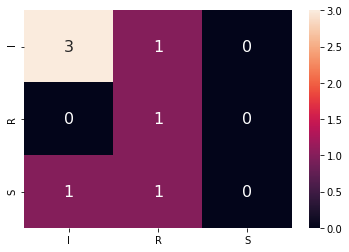

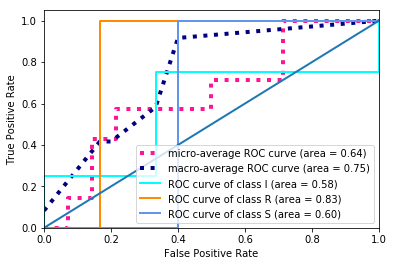


This is the classification report for the eval set:
              precision    recall  f1-score   support

           I       0.75      0.75      0.75         4
           R       0.33      1.00      0.50         1
           S       0.00      0.00      0.00         2

   micro avg       0.57      0.57      0.57         7
   macro avg       0.36      0.58      0.42         7
weighted avg       0.48      0.57      0.50         7

This is the classification report for the training set:
              precision    recall  f1-score   support

           I       0.94      1.00      0.97        33
           R       0.97      1.00      0.99        33
           S       1.00      0.80      0.89        15

   micro avg       0.96      0.96      0.96        81
   macro avg       0.97      0.93      0.95        81
weighted avg       0.96      0.96      0.96        81

Misclassified labels
Index(['24/3-11-14/8-14-14', '24b/3-11-14/8-14-14', '41/1-25-11/8-7-12'], dtype='object')
Predicted class
['

/home/anna.merkoulovitch/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/anna.merkoulovitch/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/anna.merkoulovitch/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/anna.merkoulovitch/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:53: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index


In [126]:
# THIS IS THE FINAL MULTI-CLASS MODEL
params = [{}]
eclf_multi = VotingClassifier(estimators=[('cnn',cnn_multi), ('vbow', vbow)], voting="soft", weights=[3,1])
m = GridSearchCV(eclf_multi, cv=7, param_grid = params, scoring=f1_multi_scorer)
final_info(m, X,y, X_final_test, y_final_test, multi_class=True)


Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.



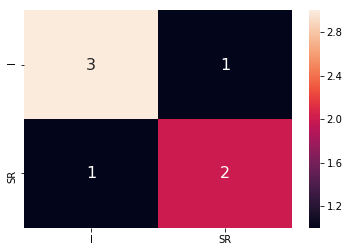

ROC AUC score
0.833333333333


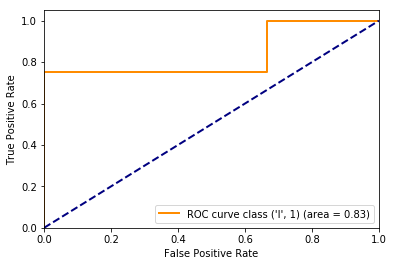


This is the classification report for the eval set:
              precision    recall  f1-score   support

           I       0.75      0.75      0.75         4
          SR       0.67      0.67      0.67         3

   micro avg       0.71      0.71      0.71         7
   macro avg       0.71      0.71      0.71         7
weighted avg       0.71      0.71      0.71         7

This is the classification report for the training set:
              precision    recall  f1-score   support

           I       1.00      1.00      1.00        33
          SR       1.00      1.00      1.00        48

   micro avg       1.00      1.00      1.00        81
   macro avg       1.00      1.00      1.00        81
weighted avg       1.00      1.00      1.00        81

Misclassified labels
Index(['24b/3-11-14/8-14-14', '41/1-25-11/8-7-12'], dtype='object')
Predicted class
['SR' 'SR' 'SR' 'SR' 'I' 'SR' 'I']
Actual class
24b/3-11-14/8-14-14    SR
41/1-25-11/8-7-12       I
Name: y, dtype: object


/home/anna.merkoulovitch/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:53: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index


In [118]:
# FINAL BINARY MODEL
eclf_binary = VotingClassifier(estimators=[('cnn',cnn_binary_knn), ('cnn2',cnn_binary), ('vbow', vbow)], voting="soft", weights=[1,3,1])
final_info(eclf_binary, X,y, X_final_test, y_final_test, multi_class=False)

#m = train_ensemble(X,y, eclf_binary, multiclass=False, cv=5, test_size=0, num_models=3, scoring=f1_bi_scorer)

### Using ideal params, but re-training

In [72]:
y_final_test

6/10-23-14/11-16-17    R
7/4-10-12/5-28-15      I
2/12-11-12/12-17-13    I
24/3-11-14/8-14-14     S
24b/3-11-14/8-14-14    S
32/12-17-15/1-5-17     I
41/1-25-11/8-7-12      I
Name: y, dtype: object

# Tuning hyper-parameter



/home/anna.merkoulovitch/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/anna.merkoulovitch/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/anna.merkoulovitch/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/anna.merkoulovitch/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted',

Best parameters set found on development set:

{'weights': [4, 1], 'voting': 'soft'}

Grid scores on development set:

0.662 (+/-0.216) for {'weights': [1, 2], 'voting': 'soft'}
0.616 (+/-0.303) for {'weights': [1, 3], 'voting': 'soft'}
0.755 (+/-0.236) for {'weights': [1, 1], 'voting': 'soft'}
0.755 (+/-0.236) for {'weights': [2, 1], 'voting': 'soft'}
0.755 (+/-0.236) for {'weights': [3, 1], 'voting': 'soft'}
0.757 (+/-0.235) for {'weights': [4, 1], 'voting': 'soft'}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.



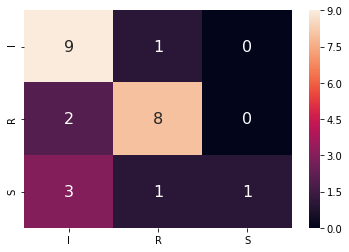

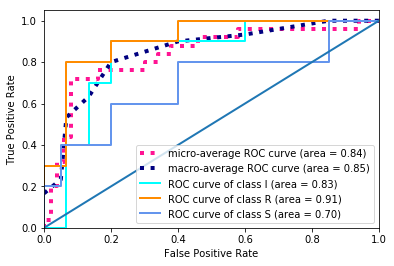


This is the classification report for the eval set:
              precision    recall  f1-score   support

           I       0.64      0.90      0.75        10
           R       0.80      0.80      0.80        10
           S       1.00      0.20      0.33         5

   micro avg       0.72      0.72      0.72        25
   macro avg       0.81      0.63      0.63        25
weighted avg       0.78      0.72      0.69        25

This is the classification report for the training set:
              precision    recall  f1-score   support

           I       0.92      1.00      0.96        23
           R       0.96      1.00      0.98        23
           S       1.00      0.70      0.82        10

   micro avg       0.95      0.95      0.95        56
   macro avg       0.96      0.90      0.92        56
weighted avg       0.95      0.95      0.94        56

Misclassified labels
Index(['12/5-29-12/4-16-13', '12/4-16-13/5-29-12', '12/4-16-13/5-24-14',
       '26/3-19-15/3-10-16', '9/6-2

/home/anna.merkoulovitch/crmo-diagnosis-using-mri/src/utils.py:148: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
  print(model.predict(X_test)[incorrect_indices])


In [88]:
eclf_multi = VotingClassifier(estimators=[('cnn2',cnn_multi), ('vbow', vbow)])
m = train_ensemble(X,y, eclf_multi, multiclass=True, cv=6, show_incorrect=True, scoring=f1_multi_scorer)

# Tuning hyper-parameter



/home/anna.merkoulovitch/anaconda3/lib/python3.5/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:

{'weights': [2, 1], 'voting': 'soft'}

Grid scores on development set:

0.786 (+/-0.142) for {'weights': [1, 2], 'voting': 'soft'}
0.714 (+/-0.278) for {'weights': [1, 3], 'voting': 'soft'}
0.804 (+/-0.204) for {'weights': [1, 1], 'voting': 'soft'}
0.821 (+/-0.181) for {'weights': [2, 1], 'voting': 'soft'}
0.821 (+/-0.181) for {'weights': [3, 1], 'voting': 'soft'}
0.821 (+/-0.181) for {'weights': [4, 1], 'voting': 'soft'}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.



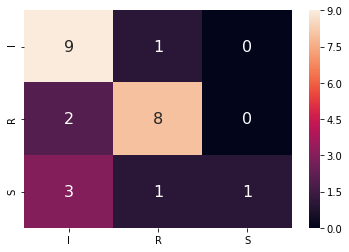

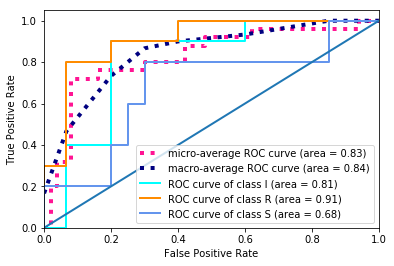


This is the classification report for the eval set:
              precision    recall  f1-score   support

           I       0.64      0.90      0.75        10
           R       0.80      0.80      0.80        10
           S       1.00      0.20      0.33         5

   micro avg       0.72      0.72      0.72        25
   macro avg       0.81      0.63      0.63        25
weighted avg       0.78      0.72      0.69        25

This is the classification report for the training set:
              precision    recall  f1-score   support

           I       1.00      1.00      1.00        23
           R       0.92      1.00      0.96        23
           S       1.00      0.80      0.89        10

   micro avg       0.96      0.96      0.96        56
   macro avg       0.97      0.93      0.95        56
weighted avg       0.97      0.96      0.96        56

Misclassified labels
Index(['12/5-29-12/4-16-13', '12/4-16-13/5-29-12', '12/4-16-13/5-24-14',
       '26/3-19-15/3-10-16', '9/6-2

/home/anna.merkoulovitch/crmo-diagnosis-using-mri/src/utils.py:148: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
  print(model.predict(X_test)[incorrect_indices])


In [130]:
eclf_multi = VotingClassifier(estimators=[('cnn2',cnn_multi), ('vbow', vbow)])
m = train_ensemble(X,y, eclf_multi, multiclass=True, cv=6, show_incorrect=True)

# Tuning hyper-parameter

Best parameters set found on development set:

{'weights': [1, 3, 3], 'voting': 'soft'}

Grid scores on development set:

0.750 (+/-0.260) for {'weights': [1, 1, 1], 'voting': 'soft'}
0.732 (+/-0.283) for {'weights': [2, 1, 1], 'voting': 'soft'}
0.732 (+/-0.283) for {'weights': [3, 1, 1], 'voting': 'soft'}
0.768 (+/-0.228) for {'weights': [1, 2, 1], 'voting': 'soft'}
0.786 (+/-0.219) for {'weights': [1, 3, 1], 'voting': 'soft'}
0.696 (+/-0.336) for {'weights': [1, 1, 2], 'voting': 'soft'}
0.750 (+/-0.260) for {'weights': [1, 1, 3], 'voting': 'soft'}
0.750 (+/-0.260) for {'weights': [2, 2, 1], 'voting': 'soft'}
0.750 (+/-0.310) for {'weights': [1, 2, 2], 'voting': 'soft'}
0.768 (+/-0.257) for {'weights': [1, 2, 3], 'voting': 'soft'}
0.732 (+/-0.283) for {'weights': [3, 2, 1], 'voting': 'soft'}
0.804 (+/-0.204) for {'weights': [1, 3, 3], 'voting': 'soft'}

Detailed classification report:

The model is trained on the full development set.
The scores are computed 

/home/anna.merkoulovitch/anaconda3/lib/python3.5/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


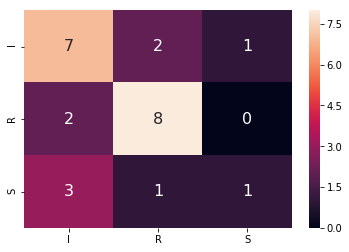

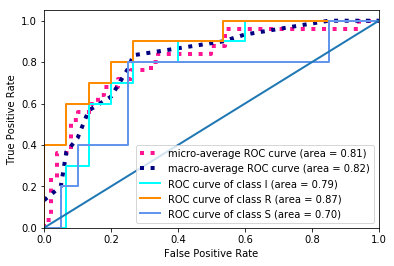


This is the classification report for the eval set:
              precision    recall  f1-score   support

           I       0.58      0.70      0.64        10
           R       0.73      0.80      0.76        10
           S       0.50      0.20      0.29         5

   micro avg       0.64      0.64      0.64        25
   macro avg       0.60      0.57      0.56        25
weighted avg       0.62      0.64      0.62        25

This is the classification report for the training set:
              precision    recall  f1-score   support

           I       0.69      0.78      0.73        23
           R       0.75      0.65      0.70        23
           S       1.00      1.00      1.00        10

   micro avg       0.77      0.77      0.77        56
   macro avg       0.81      0.81      0.81        56
weighted avg       0.77      0.77      0.77        56

Misclassified labels
Index(['12/5-29-12/4-16-13', '1/10-05-15/10-06-14', '12/4-16-13/5-29-12',
       '12/4-16-13/5-24-14', '26/3

/home/anna.merkoulovitch/crmo-diagnosis-using-mri/src/utils.py:148: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
  print(model.predict(X_test)[incorrect_indices])


In [73]:
eclf_multi = VotingClassifier(estimators=[('cnn',cnn_multi_knn), ('cnn2',cnn_multi), ('vbow', vbow)])
m = train_ensemble(X,y, eclf_multi, multiclass=True, cv=6, show_incorrect=True, num_models=3)

# Tuning hyper-parameter

Best parameters set found on development set:

{'weights': [2, 1], 'voting': 'soft'}

Grid scores on development set:

0.554 (+/-0.297) for {'weights': [1, 2], 'voting': 'soft'}
0.554 (+/-0.331) for {'weights': [1, 3], 'voting': 'soft'}
0.571 (+/-0.306) for {'weights': [1, 1], 'voting': 'soft'}
0.589 (+/-0.274) for {'weights': [2, 1], 'voting': 'soft'}
0.571 (+/-0.294) for {'weights': [3, 1], 'voting': 'soft'}
0.571 (+/-0.294) for {'weights': [4, 1], 'voting': 'soft'}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.



/home/anna.merkoulovitch/anaconda3/lib/python3.5/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


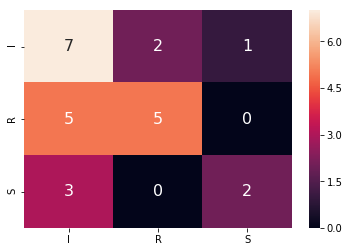

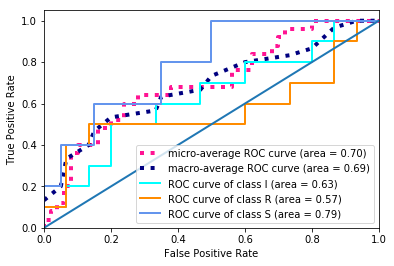


This is the classification report for the eval set:
              precision    recall  f1-score   support

           I       0.47      0.70      0.56        10
           R       0.71      0.50      0.59        10
           S       0.67      0.40      0.50         5

   micro avg       0.56      0.56      0.56        25
   macro avg       0.62      0.53      0.55        25
weighted avg       0.61      0.56      0.56        25

This is the classification report for the training set:
              precision    recall  f1-score   support

           I       0.65      0.57      0.60        23
           R       0.60      0.65      0.63        23
           S       0.45      0.50      0.48        10

   micro avg       0.59      0.59      0.59        56
   macro avg       0.57      0.57      0.57        56
weighted avg       0.59      0.59      0.59        56

Misclassified labels
Index(['35/10-15-15/9-4-14', '1/10-05-15/10-06-14', '12/4-16-13/5-29-12',
       '1/11-21-16/10-05-15', '12/

/home/anna.merkoulovitch/crmo-diagnosis-using-mri/src/utils.py:148: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
  print(model.predict(X_test)[incorrect_indices])


In [37]:
eclf_multi = VotingClassifier(estimators=[('cnn',cnn_multi_knn), ('vbow', vbow)])
m = train_ensemble(X,y, eclf_multi, multiclass=True, cv=6, show_incorrect=True)

# Tuning hyper-parameter

Best parameters set found on development set:

{'weights': [1, 1], 'voting': 'soft'}

Grid scores on development set:

0.786 (+/-0.219) for {'weights': [1, 2], 'voting': 'soft'}
0.750 (+/-0.116) for {'weights': [1, 3], 'voting': 'soft'}
0.839 (+/-0.188) for {'weights': [1, 1], 'voting': 'soft'}
0.839 (+/-0.146) for {'weights': [2, 1], 'voting': 'soft'}
0.839 (+/-0.146) for {'weights': [3, 1], 'voting': 'soft'}
0.839 (+/-0.146) for {'weights': [4, 1], 'voting': 'soft'}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.



/home/anna.merkoulovitch/anaconda3/lib/python3.5/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


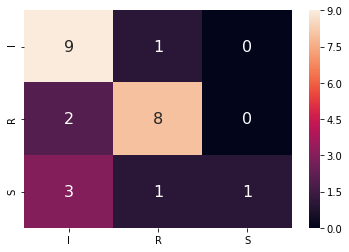

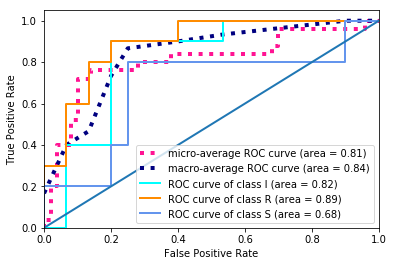


This is the classification report for the eval set:
              precision    recall  f1-score   support

           I       0.64      0.90      0.75        10
           R       0.80      0.80      0.80        10
           S       1.00      0.20      0.33         5

   micro avg       0.72      0.72      0.72        25
   macro avg       0.81      0.63      0.63        25
weighted avg       0.78      0.72      0.69        25

This is the classification report for the training set:
              precision    recall  f1-score   support

           I       1.00      1.00      1.00        23
           R       1.00      1.00      1.00        23
           S       1.00      1.00      1.00        10

   micro avg       1.00      1.00      1.00        56
   macro avg       1.00      1.00      1.00        56
weighted avg       1.00      1.00      1.00        56

Misclassified labels
Index(['12/5-29-12/4-16-13', '12/4-16-13/5-29-12', '12/4-16-13/5-24-14',
       '26/3-19-15/3-10-16', '9/6-2

/home/anna.merkoulovitch/crmo-diagnosis-using-mri/src/utils.py:148: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
  print(model.predict(X_test)[incorrect_indices])


VotingClassifier(estimators=[('cnn', Pipeline(memory=None,
     steps=[('col_extract_cnn', ColumnExtractor(pref='cnn_')), ('cnn_model', LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=3000, multi_class='multinomial',
          n_jobs=None, penalty=...  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False))]))],
         flatten_transform=None, n_jobs=None, voting='soft',
         weights=[1, 1])

In [27]:
eclf_multi = VotingClassifier(estimators=[('cnn',cnn_multi),('vbow', vbow)])
train_ensemble(X,y, eclf_multi, multiclass=True, cv=6, show_incorrect=True)

# Tuning hyper-parameter

Best parameters set found on development set:

{'weights': [1, 3, 1], 'voting': 'soft'}

Grid scores on development set:

0.744 (+/-0.337) for {'weights': [1, 1, 1], 'voting': 'soft'}
0.738 (+/-0.365) for {'weights': [2, 1, 1], 'voting': 'soft'}
0.725 (+/-0.391) for {'weights': [3, 1, 1], 'voting': 'soft'}
0.775 (+/-0.312) for {'weights': [1, 2, 1], 'voting': 'soft'}
0.790 (+/-0.254) for {'weights': [1, 3, 1], 'voting': 'soft'}
0.653 (+/-0.368) for {'weights': [1, 1, 2], 'voting': 'soft'}
0.559 (+/-0.274) for {'weights': [1, 1, 3], 'voting': 'soft'}
0.744 (+/-0.337) for {'weights': [2, 2, 1], 'voting': 'soft'}
0.751 (+/-0.250) for {'weights': [1, 2, 2], 'voting': 'soft'}
0.662 (+/-0.158) for {'weights': [1, 2, 3], 'voting': 'soft'}
0.725 (+/-0.391) for {'weights': [3, 2, 1], 'voting': 'soft'}
0.722 (+/-0.207) for {'weights': [1, 3, 3], 'voting': 'soft'}

Detailed classification report:

The model is trained on the full development set.
The scores are computed 

/home/anna.merkoulovitch/anaconda3/lib/python3.5/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


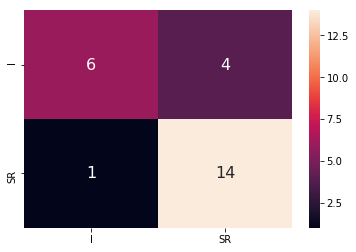

ROC AUC score
0.926666666667


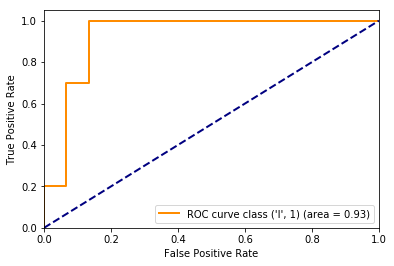


This is the classification report for the eval set:
              precision    recall  f1-score   support

           I       0.86      0.60      0.71        10
          SR       0.78      0.93      0.85        15

   micro avg       0.80      0.80      0.80        25
   macro avg       0.82      0.77      0.78        25
weighted avg       0.81      0.80      0.79        25

This is the classification report for the training set:
              precision    recall  f1-score   support

           I       0.85      0.74      0.79        23
          SR       0.83      0.91      0.87        33

   micro avg       0.84      0.84      0.84        56
   macro avg       0.84      0.82      0.83        56
weighted avg       0.84      0.84      0.84        56

Misclassified labels
Index(['12/5-29-12/4-16-13', '7b/4-10-12/5-28-15', '1/11-20-13/10-06-14',
       '10/11-7-12/8-13-15', '9/3-23-17/6-20-18'],
      dtype='object')
Predicted class
['I' 'I' 'I' 'SR' 'I' 'SR' 'I' 'I' 'I' 'I' 'I' 'I' 'I

/home/anna.merkoulovitch/crmo-diagnosis-using-mri/src/utils.py:148: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
  print(model.predict(X_test)[incorrect_indices])


In [96]:
eclf_binary = VotingClassifier(estimators=[('cnn',cnn_binary_knn), ('cnn2',cnn_binary), ('vbow', vbow)])
m = train_ensemble(X,y, eclf_binary, multiclass=False, cv=5, show_incorrect=True, num_models=3, scoring=f1_bi_scorer)

# Tuning hyper-parameter

Best parameters set found on development set:

{'weights': [1, 2, 1], 'voting': 'soft'}

Grid scores on development set:

0.786 (+/-0.101) for {'weights': [1, 1, 1], 'voting': 'soft'}
0.750 (+/-0.124) for {'weights': [2, 1, 1], 'voting': 'soft'}
0.750 (+/-0.124) for {'weights': [3, 1, 1], 'voting': 'soft'}
0.821 (+/-0.096) for {'weights': [1, 2, 1], 'voting': 'soft'}
0.821 (+/-0.145) for {'weights': [1, 3, 1], 'voting': 'soft'}
0.804 (+/-0.210) for {'weights': [1, 1, 2], 'voting': 'soft'}
0.714 (+/-0.229) for {'weights': [1, 1, 3], 'voting': 'soft'}
0.768 (+/-0.118) for {'weights': [2, 2, 1], 'voting': 'soft'}
0.768 (+/-0.210) for {'weights': [1, 2, 2], 'voting': 'soft'}
0.786 (+/-0.234) for {'weights': [1, 2, 3], 'voting': 'soft'}
0.768 (+/-0.071) for {'weights': [3, 2, 1], 'voting': 'soft'}
0.750 (+/-0.183) for {'weights': [1, 3, 3], 'voting': 'soft'}

Detailed classification report:

The model is trained on the full development set.
The scores are computed 

/home/anna.merkoulovitch/anaconda3/lib/python3.5/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


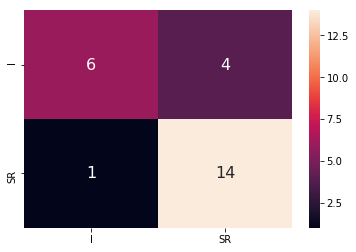

ROC AUC score
0.933333333333


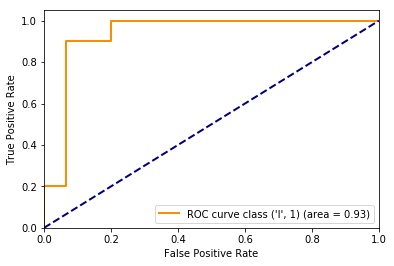


This is the classification report for the eval set:
              precision    recall  f1-score   support

           I       0.86      0.60      0.71        10
          SR       0.78      0.93      0.85        15

   micro avg       0.80      0.80      0.80        25
   macro avg       0.82      0.77      0.78        25
weighted avg       0.81      0.80      0.79        25

This is the classification report for the training set:
              precision    recall  f1-score   support

           I       0.90      0.83      0.86        23
          SR       0.89      0.94      0.91        33

   micro avg       0.89      0.89      0.89        56
   macro avg       0.90      0.88      0.89        56
weighted avg       0.89      0.89      0.89        56

Misclassified labels
Index(['12/5-29-12/4-16-13', '7b/4-10-12/5-28-15', '1/11-20-13/10-06-14',
       '10/11-7-12/8-13-15', '9/3-23-17/6-20-18'],
      dtype='object')
Predicted class
['I' 'I' 'I' 'SR' 'I' 'SR' 'I' 'I' 'I' 'I' 'I' 'I' 'I

/home/anna.merkoulovitch/crmo-diagnosis-using-mri/src/utils.py:148: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
  print(model.predict(X_test)[incorrect_indices])


In [92]:
eclf_binary = VotingClassifier(estimators=[('cnn',cnn_binary_knn), ('cnn2',cnn_binary), ('vbow', vbow)])
m = train_ensemble(X,y, eclf_binary, multiclass=False, cv=6, show_incorrect=True, num_models=3)

# Tuning hyper-parameter

Best parameters set found on development set:

{'weights': [1, 2], 'voting': 'soft'}

Grid scores on development set:

0.750 (+/-0.180) for {'weights': [1, 2], 'voting': 'soft'}
0.679 (+/-0.136) for {'weights': [1, 3], 'voting': 'soft'}
0.732 (+/-0.118) for {'weights': [1, 1], 'voting': 'soft'}
0.750 (+/-0.124) for {'weights': [2, 1], 'voting': 'soft'}
0.750 (+/-0.124) for {'weights': [3, 1], 'voting': 'soft'}
0.750 (+/-0.124) for {'weights': [4, 1], 'voting': 'soft'}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.



/home/anna.merkoulovitch/anaconda3/lib/python3.5/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


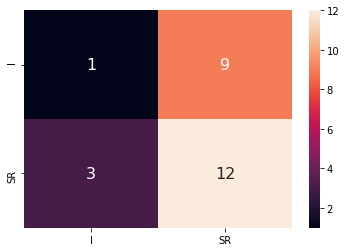

ROC AUC score
0.446666666667


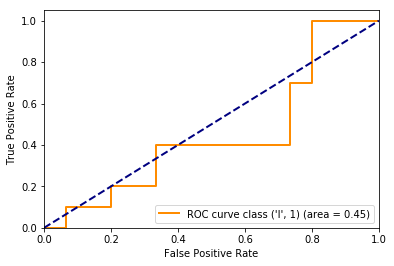


This is the classification report for the eval set:
              precision    recall  f1-score   support

           I       0.25      0.10      0.14        10
          SR       0.57      0.80      0.67        15

   micro avg       0.52      0.52      0.52        25
   macro avg       0.41      0.45      0.40        25
weighted avg       0.44      0.52      0.46        25

This is the classification report for the training set:
              precision    recall  f1-score   support

           I       0.00      0.00      0.00        23
          SR       0.00      0.00      0.00        33

   micro avg       0.00      0.00      0.00        56
   macro avg       0.00      0.00      0.00        56
weighted avg       0.00      0.00      0.00        56

Misclassified labels
Index(['10/6-21-17/9-22-16', '12/5-29-12/4-16-13', '7b/4-10-12/5-28-15',
       '10/8-13-15/6-21-17', '1/10-05-15/10-06-14', '35/9-4-14/10-15-15',
       '35/9-4-14/12-30-16', '10/11-7-12/8-13-15', '10/8-13-15/11-7-1

/home/anna.merkoulovitch/crmo-diagnosis-using-mri/src/utils.py:148: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
  print(model.predict(X_test)[incorrect_indices])


In [79]:
eclf_binary = VotingClassifier(estimators=[('cnn',cnn_binary_knn), ('vbow', vbow)]) # BAD
m = train_ensemble(X,y, eclf_binary, multiclass=False, cv=6, show_incorrect=True)

# Tuning hyper-parameter



/home/anna.merkoulovitch/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/anna.merkoulovitch/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/anna.merkoulovitch/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/anna.merkoulovitch/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/anna.m

Best parameters set found on development set:

{'weights': [3, 1], 'voting': 'soft'}

Grid scores on development set:

0.298 (+/-0.291) for {'weights': [1, 2], 'voting': 'soft'}
0.117 (+/-0.375) for {'weights': [1, 3], 'voting': 'soft'}
0.430 (+/-0.582) for {'weights': [1, 1], 'voting': 'soft'}
0.724 (+/-0.314) for {'weights': [2, 1], 'voting': 'soft'}
0.794 (+/-0.230) for {'weights': [3, 1], 'voting': 'soft'}
0.779 (+/-0.250) for {'weights': [4, 1], 'voting': 'soft'}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.



/home/anna.merkoulovitch/anaconda3/lib/python3.5/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


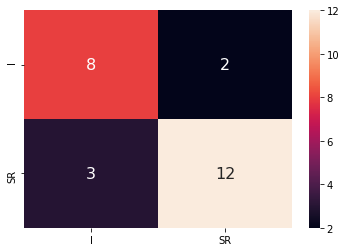

ROC AUC score
0.893333333333


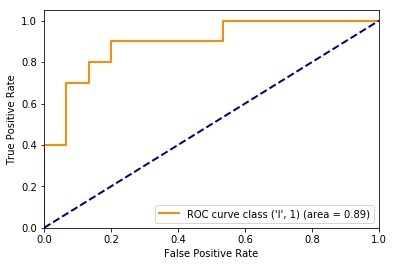


This is the classification report for the eval set:
              precision    recall  f1-score   support

           I       0.73      0.80      0.76        10
          SR       0.86      0.80      0.83        15

   micro avg       0.80      0.80      0.80        25
   macro avg       0.79      0.80      0.79        25
weighted avg       0.81      0.80      0.80        25

This is the classification report for the training set:
              precision    recall  f1-score   support

           I       0.69      0.48      0.56        23
          SR       0.70      0.85      0.77        33

   micro avg       0.70      0.70      0.70        56
   macro avg       0.69      0.66      0.67        56
weighted avg       0.69      0.70      0.68        56

Misclassified labels
Index(['7b/5-28-15/4-10-12', '10/3-7-14/9-22-16', '7b/4-10-12/5-28-15',
       '1/11-20-13/10-06-14', '9/3-23-17/6-20-18'],
      dtype='object')
Predicted class
['I' 'I' 'I' 'I' 'I' 'I' 'I' 'I' 'I' 'I' 'I' 'I' 'I' '

/home/anna.merkoulovitch/crmo-diagnosis-using-mri/src/utils.py:148: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
  print(model.predict(X_test)[incorrect_indices])


In [94]:
eclf_binary = VotingClassifier(estimators=[('cnn',cnn_binary),('vbow', vbow)])
binary_model = train_ensemble(X,y, eclf_binary, multiclass=False, cv=6, show_incorrect=True, scoring=f1_bi_scorer)

# Tuning hyper-parameter

Best parameters set found on development set:

{'weights': [3, 1], 'voting': 'soft'}

Grid scores on development set:

0.589 (+/-0.181) for {'weights': [1, 2], 'voting': 'soft'}
0.571 (+/-0.082) for {'weights': [1, 3], 'voting': 'soft'}
0.696 (+/-0.161) for {'weights': [1, 1], 'voting': 'soft'}
0.750 (+/-0.172) for {'weights': [2, 1], 'voting': 'soft'}
0.857 (+/-0.149) for {'weights': [3, 1], 'voting': 'soft'}
0.839 (+/-0.201) for {'weights': [4, 1], 'voting': 'soft'}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.



/home/anna.merkoulovitch/anaconda3/lib/python3.5/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


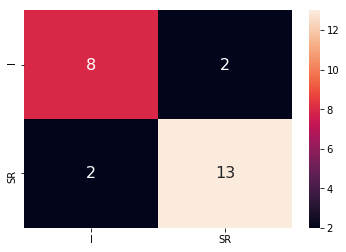

ROC AUC score
0.9


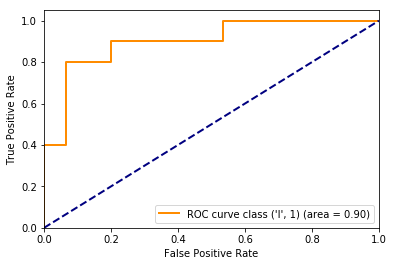


This is the classification report for the eval set:
              precision    recall  f1-score   support

           I       0.80      0.80      0.80        10
          SR       0.87      0.87      0.87        15

   micro avg       0.84      0.84      0.84        25
   macro avg       0.83      0.83      0.83        25
weighted avg       0.84      0.84      0.84        25

This is the classification report for the training set:
              precision    recall  f1-score   support

           I       0.87      0.57      0.68        23
          SR       0.76      0.94      0.84        33

   micro avg       0.79      0.79      0.79        56
   macro avg       0.81      0.75      0.76        56
weighted avg       0.80      0.79      0.77        56

Misclassified labels
Index(['7b/5-28-15/4-10-12', '7b/4-10-12/5-28-15', '1/11-20-13/10-06-14',
       '9/3-23-17/6-20-18'],
      dtype='object')
Predicted class
['I' 'I' 'I' 'I' 'I' 'I' 'I' 'I' 'I' 'I' 'I' 'I' 'I' 'I' 'I' 'I' 'I' 'I'
 '

/home/anna.merkoulovitch/crmo-diagnosis-using-mri/src/utils.py:148: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
  print(model.predict(X_test)[incorrect_indices])


In [81]:
eclf_binary = VotingClassifier(estimators=[('cnn',cnn_binary),('vbow', vbow)])
binary_model = train_ensemble(X,y, eclf_binary, multiclass=False, cv=6, show_incorrect=True)

### IGNORE

In [120]:
import cv2
import numpy as np
import operator

from matplotlib import pyplot as plt
import seaborn as sn
import pandas as pd
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc, classification_report, confusion_matrix
from itertools import cycle
from sklearn.preprocessing import label_binarize
from scipy import interp
from sklearn.svm import SVC
def final_info(model,X_train,y_train,X_test,y_test, multi_class=False):
    if not multi_class:
        y_train = y_train.replace('S', 'SR')
        y_train = y_train.replace('R', 'SR')
        y_test = y_test.replace('S', 'SR')
        y_test = y_test.replace('R', 'SR')
    model.fit(X_train,y_train)
    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_pred = model.predict(X_test)
    utils.plot_confusion_matrix(y_test, y_pred)
    if multi_class == False:
        my_dict = {'I':1, 'SR':-1}
        print("ROC AUC score")
        vectorized = np.vectorize(my_dict.get)(y_test)
        # sort classes by label value so they match up with vectorized
        classes = sorted(my_dict.items(), key=operator.itemgetter(0))
        print(roc_auc_score(vectorized, model.predict_proba(X_test)[:, 0]))
        utils.plot_roc_binary(vectorized, model.predict_proba(X_test), classes)
    else:
        utils.plot_roc_multi(y_test, model.predict_proba(X_test),
                       model.classes_)
    print()
    print("This is the classification report for the eval set:")
    print(classification_report(y_test, y_pred))

    print("This is the classification report for the training set:")
    y_train_pred = model.predict(X_train)
    print(classification_report(y_train, y_train_pred))

    # Not using actual function here since this is being run on a google compute w.o. the images
    incorrect_indices = np.logical_not(model.predict(X_test) == y_test)
    print("Misclassified labels")
    print(X_test.index[incorrect_indices])
    print("Predicted class")
    print(model.predict(X_test)[incorrect_indices])
    print("Actual class")
    print(y_test[incorrect_indices])